---
title: 'AMNE 376: A Study of Richter''s Kouroi Through Image Embedding'
author: prAxIs UBC Team <br> Kaiyan Zhang, Yash Mali, Krishaant Pathman
date: July 2025
---

Before you start, make sure you have the required libraries installed, if not, simply **uncomment the lines below** (use `Ctrl + /`) and run the cell to install them: 

In [1]:
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install opencv-python
# !pip install sklearn
# !pip install torch
# !pip install torchvision
# !pip install transformers
# !pip install datasets
# !pip install grad-cam
# !pip install tensorflow
# !pip install keras

### 1. Introduction: How Computers See Visual Art?

In this notebook, we explore a dataset of photographs collected from Gisela Richter's ***Kouroi: Archaic Greek Youths: a Study of the Development of the Kouros Type in Greek Sculpture (1942)***.

Gisela Richter's 1942 book was one of the first systematic efforts to catalog and classify kouroi based on their stylistic evolution. Her work combined archaeological evidence with visual comparison, laying the foundation for how we study ancient sculpture today.

In this project, we aim to apply computer vision techniques to digitally analyze and group images from this dataset. Just as Richter used her trained eye to identify patterns and typologies, we'll explore how machines can "see" these sculptures through their eyes (image embeddings, clustering, and convolutional neural networks).

Have you ever wondered how images are stored in computers, how computers see them and distinguish the difference between them? 

Many of you probably know digital images are stored based on pixels as a grid of figures, but when we are doing image searches using a search engine or uploading them to a Generative AI model, how are computers interpret them, distinguish the difference and process them exactly? Here is a brief introduction that introduce you to some of the basic forms and methods.

#### 1.1 Digital Representations of Images

Have you ever heard of the RGB primary color model? For those who are unfamiliar with the concept, the model uses numbers in a range 0 ~ 255 to represent the color intensity of red, green and blue and add up the three color channels to generate any color that's visible to human. In a colorful digital image, each pixel is characterized by its color stored in the form (R, G, B), so knowing the distribution of color intensity gives you a lot of information about the image. 

However, for monochrome images, there is only one color channel, the grayscale. We can still use the distribution of grayscale intensities to represent the image. Since all of our images (cropped from scanned pdf books) are printed in monochrome, we can represent them using a **grayscale color histogram**. 

Let's start with a three-view of the New York Kouros, here we read in the images and present them together.

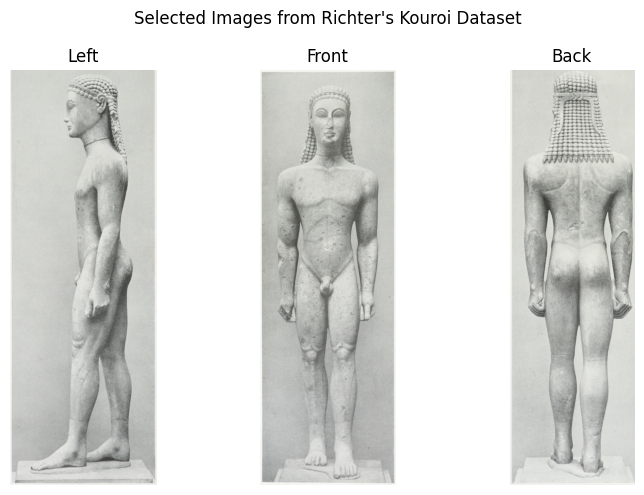

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the folder path where the images are stored
image_path = '../data/richter_kouroi_filtered_photos' 

fig, axes = plt.subplots(1, 3, figsize=(8, 5))

# List of specific image filenames
image_names = {'page188_img01_photo12.jpg': "Left", 'page188_img01_photo13.jpg': "Front", 'page189_img01_photo3.jpg': "Back"}

# Display the images side by side
axes = axes.flatten()
for i, img_name in enumerate(image_names):
    img_path = f"{image_path}/{img_name}"
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].set_title(image_names[img_name])
    axes[i].axis('off')

plt.suptitle("Selected Images from Richter's Kouroi Dataset")
plt.tight_layout()
plt.show()

Each of these images, when loaded into the computer, becomes a 2D array of numbers representing **intensity values**. We then plot the color histogram for each image representing the distribution of **grayscale intensity**. What do you notice by looking at the three histograms?

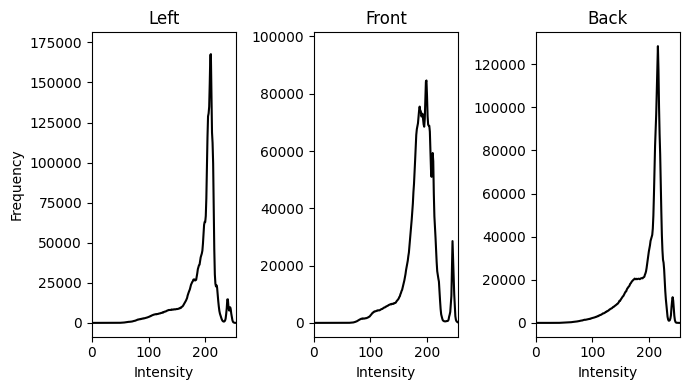

In [3]:
# Generate and plot greyscale histograms for the selected images
fig, axes = plt.subplots(1, 3, figsize=(7, 4))

for i, img_name in enumerate(image_names):
    img_path = f"{image_path}/{img_name}"
    image = Image.open(img_path)
    histogram = image.histogram()

    axes[i].plot(histogram, color='black')
    axes[i].set_title(f'{image_names[img_name]}')
    axes[i].set_xlim([0, 255])
    axes[i].set_xlabel("Intensity")
    if i == 0:
        axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

They look very similar! This result is not surprising given that the three images were taken at the same time with the same equipment of the same Kouros. The above example shows us that comparing the similarity of color distributions is one way that computers understand the similarity of images.

However, one can quickly realize the drawbacks of this approach. First, it relies on the correct representation of color, so two identical images with color differences may not be recognized as similar. Second, since it focuses only on color, it ignores the fundamental information for object recognition such as spatial, shape and texture in the image. Last but not least, there may exist two completely different images with exactly the same color distribution. Therefore, we need better methods to consider the similarity between images.

**Bag of Visual Words (BoVW)** is a more practical method for recognizing similarity. The rationale behind this is very complicated, but to put it simply, it treats a “feature” in an image as a “word” (a set of numbers containing information about the feature) and calculates how often each word appears in the image. Here, we created a visual vocabulary containing 20 “words” using three-view photos of the New York Kouros, and visualized what a visual word represents on the left-view image. Here, we pick the visual word with ID 6: 

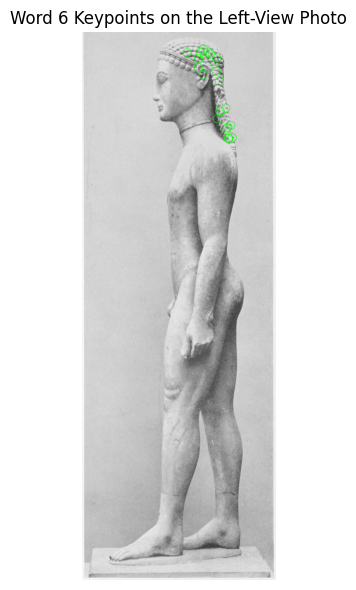

In [4]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import defaultdict

# Define the number of clusters for KMeans
n_clusters   = 20
word_to_show = 6
max_patches  = 30

# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=500)
all_descriptors = []      # for stacking
image_data      = []      # (img_name, kps, descs)

# Detect and describe all images
for img_name in image_names:
    img_path = os.path.join(image_path, img_name)
    img      = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = orb.detectAndCompute(img, None)

    if descriptors is None:
        descriptors = np.zeros((0, orb.descriptorSize()), dtype=np.uint8)

    all_descriptors.append(descriptors)
    image_data.append((img_name, keypoints, descriptors))

# Build the visual vocabulary
all_descriptors_stacked = np.vstack(all_descriptors)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_descriptors_stacked)

# Compute BoVW histograms
histograms = []
for img_name, _, descriptors in image_data:
    if descriptors.shape[0] > 0:
        words = kmeans.predict(descriptors)
        hist, _ = np.histogram(words, bins=np.arange(n_clusters + 1))
    else:
        hist = np.zeros(n_clusters, dtype=int)
    histograms.append((img_name, hist))

# Find the locations matching visual word ID = 6
locations = []
for img_idx, (_, keypoints, descriptors) in enumerate(image_data):
    if descriptors.shape[0] == 0:
        continue
    assignments = kmeans.predict(descriptors)
    for kp, w in zip(keypoints, assignments):
        if w == word_to_show:
            x, y = map(int, kp.pt)
            locations.append((img_idx, x, y))
            if len(locations) >= max_patches:
                break
    if len(locations) >= max_patches:
        break

# Group by image and visualize
imgs = defaultdict(list)
for idx, x, y in locations:
    imgs[idx].append((x, y))

if imgs:
    img_idx, pts = next(iter(imgs.items()))
    fname = image_data[img_idx][0]
    img   = cv2.imread(os.path.join(image_path, fname), cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for x, y in pts:
        cv2.circle(img_rgb, (x, y), radius=25, color=(0,255,0), thickness=2)

    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.title(f"Word {word_to_show} Keypoints on the Left-View Photo")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

We note that the word 6 could represent the beads in the beadwork worn by the Kouros. Based on your knowledge of the various Kouros, do you think this visual word can be the key to differentiating between different Kouros, or even different sculptural subjects?


#### 1.2 Measurement of Similarity

As you may have realized, the visual word frequency distributions of different images are not exactly the same, so how can we determine if these images are similar? More importantly, what can we use as a criterion to categorize different images based on visual words? Here, we will use something called **cosine similarity** to make a measurement.
<!-- ```{=html}
<iframe src="../data/cosine_demo.html" width="600" height="600" style="border:none;"></iframe>
``` -->

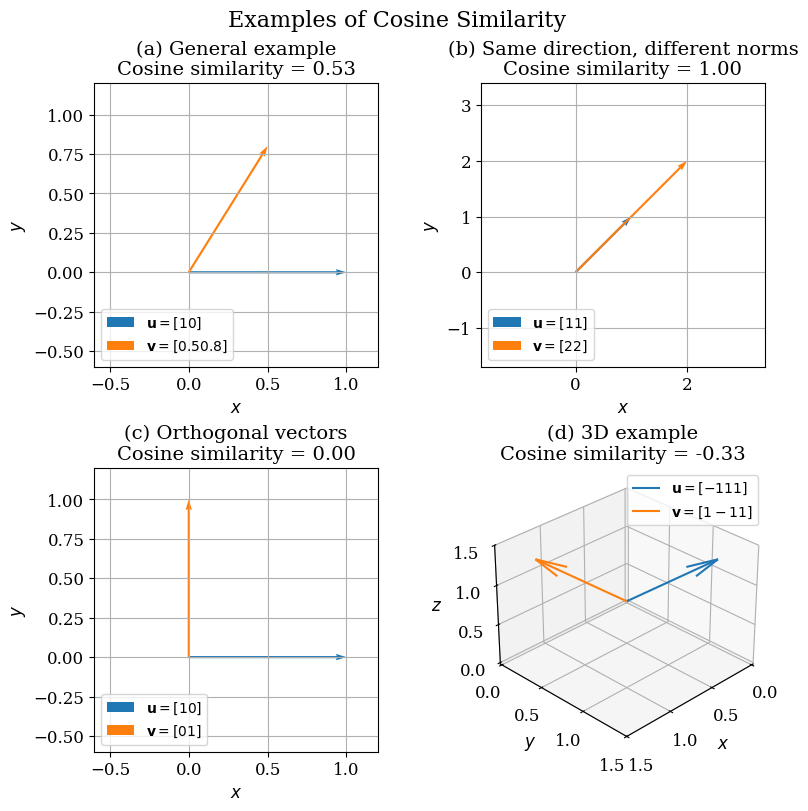

In [5]:
#| echo: false
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Academic style settings
plt.rc('font', family='serif', size=12)
plt.rc('axes', titlesize=14, labelsize=12)
plt.rc('legend', fontsize=10)
plt.rc('figure', titlesize=16)

# Define vectors for each scenario
# (a) general example
v1_a = np.array([1, 0])
v2_a = np.array([0.5, 0.8])
# (b) same direction, different norms
v1_b = np.array([1, 1])
v2_b = np.array([2, 2])
# (c) orthogonal vectors
v1_c = np.array([1, 0])
v2_c = np.array([0, 1])
# (d) 3D example
v1_d = np.array([-1, 1, 1])
v2_d = np.array([1, -1, 1])

# Function to compute cosine similarity
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# Set up figure and subplots
grid = plt.figure(constrained_layout=True, figsize=(8, 8))
sub_a = grid.add_subplot(2, 2, 1)
sub_b = grid.add_subplot(2, 2, 2)
sub_c = grid.add_subplot(2, 2, 3)
sub_d = grid.add_subplot(2, 2, 4, projection='3d')

# Plot helper for 2D vectors
def plot_2d(ax, u, v, title, color_u='C0', color_v='C1'):
    # Plot vectors
    ax.quiver(0, 0, u[0], u[1], angles='xy', scale_units='xy', scale=1,
              color=color_u, label=r'$\mathbf{{u}}={} $'.format(u))
    ax.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1,
              color=color_v, label=r'$\mathbf{{v}}={} $'.format(v))
    # Compute cosine similarity
    cos_sim = cosine_similarity(u, v)
    # Title and labels
    ax.set_title(f"{title}\nCosine similarity = {cos_sim:.2f}")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(True)
    ax.legend(loc='lower left')
    # Set axis limits to keep vectors in view
    max_val = max(np.linalg.norm(u), np.linalg.norm(v)) * 1.2
    ax.set_xlim(-max_val + 0.5*max_val, max_val)
    ax.set_ylim(-max_val + 0.5*max_val, max_val)
    ax.set_aspect('equal')

# (a) General example
plot_2d(sub_a, v1_a, v2_a, '(a) General example')
# (b) Same direction, different norms
plot_2d(sub_b, v1_b, v2_b, '(b) Same direction, different norms')
# (c) Orthogonal vectors
plot_2d(sub_c, v1_c, v2_c, '(c) Orthogonal vectors')

# (d) 3D static visualization
ux, uy, uz = v1_d
vx, vy, vz = v2_d
sub_d.quiver(0, 0, 0, ux, uy, uz, length=1.0, normalize=True, color='C0',
             label=r'$\mathbf{{u}}={} $'.format(v1_d))
sub_d.quiver(0, 0, 0, vx, vy, vz, length=1.0, normalize=True, color='C1',
             label=r'$\mathbf{{v}}={} $'.format(v2_d))
cos_sim_d = cosine_similarity(v1_d, v2_d)
sub_d.set_title(f"(d) 3D example\nCosine similarity = {cos_sim_d:.2f}")
sub_d.set_xlabel('$x$')
sub_d.set_ylabel('$y$')
sub_d.set_zlabel('$z$')
sub_d.legend(loc='best')

# Adjust 3D axis limits symmetrically around origin
def set_symmetric_limits(ax, vectors, margin=1.2):
    norms = [np.linalg.norm(vec) for vec in vectors]
    max_norm = max(norms) * margin
    ax.set_xlim(-0.02, 1.5)
    ax.set_ylim(-0.02, 1.5)
    ax.set_zlim(-0.02, 1.5)

set_symmetric_limits(sub_d, [v1_d, v2_d])

# Modify viewing angle so origin appears at back
sub_d.view_init(elev=30, azim=45)

# Show all plots
plt.suptitle("Examples of Cosine Similarity")
plt.show()

You can think of the visual word frequency histogram for each image as an arrow in space, and cosine similarity is a measure of how much those arrows are pointing in the same direction. The criterion is very intuitive: the closer the cosine similarity of two images is to 1, the more similar the two images are; the closer the cosine similarity is to 0, the less similar the two images are.

Here, we perform pairwise cosine similarity measurements on left-view, front-view, and back-view photographs of New York Kouros, and show the results.

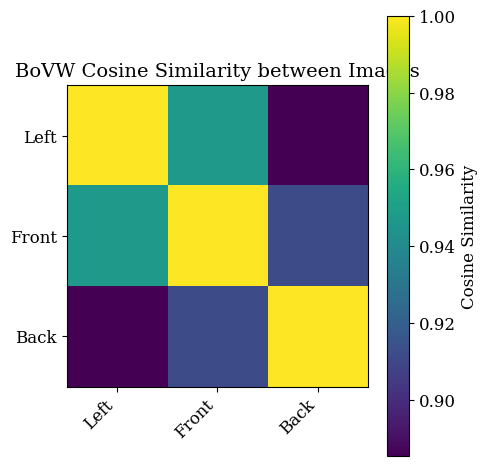

Pairwise Cosine Similarity Matrix:
Left vs Front: 0.947
Left vs Back: 0.885
Front vs Back: 0.912


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

hist_list = []
for img_name, _, descriptors in image_data:
    if descriptors.shape[0] > 0:
        words = kmeans.predict(descriptors)
        hist, _ = np.histogram(words, bins=np.arange(n_clusters + 1))
    else:
        hist = np.zeros(n_clusters, dtype=int)
    hist = hist.astype(float)
    if hist.sum() > 0:
        hist /= hist.sum()
    hist_list.append(hist)
    
histograms = np.array(hist_list)

sim_matrix = cosine_similarity(histograms)

image_keys = list(image_names.keys())
image_labels = list(image_names.values())

# Display the similarity matrix
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(sim_matrix, interpolation='nearest', cmap='viridis')
ax.set_title('BoVW Cosine Similarity between Images')
ax.set_xticks(np.arange(len(image_labels)))
ax.set_yticks(np.arange(len(image_labels)))
ax.set_xticklabels(image_labels, rotation=45, ha='right')
ax.set_yticklabels(image_labels)
fig.colorbar(cax, ax=ax, label='Cosine Similarity')
plt.tight_layout()
plt.show()

print("Pairwise Cosine Similarity Matrix:")
for i in range(len(image_labels)):
    for j in range(i + 1, len(image_labels)):
        print(f"{image_labels[i]} vs {image_labels[j]}: {sim_matrix[i, j]:.3f}")

As you can see, the pairwise cosine similarities are all very high, even though the BoVW histograms look very different! This is good evidence that they are photographs of the same object, and computers can understand this by setting appropriate threshold. 

However, would this also work for photos of different objects? Let's find out by calculating the cosine similarity between existing images and another Kouros currently exhibited in Piraeus Archaeological Museum.


Cosine Similarity of 'A Kouros from Athens' with existing images:
Left vs A Kouros from Athens: 0.816
Front vs A Kouros from Athens: 0.892
Back vs A Kouros from Athens: 0.839


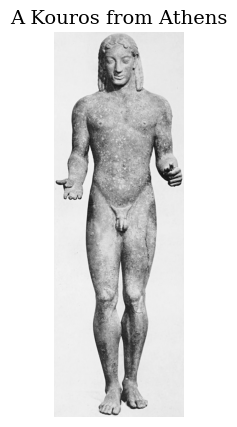

In [7]:
# Define a new image to compare with the existing ones
new_image_path = '../data/richter_kouroi_filtered_photos/page312_img01_photo4.jpg'
new_image_label = 'A Kouros from Athens' # Suppose this is a new artifact we just discovered

img_new = cv2.imread(new_image_path, cv2.IMREAD_GRAYSCALE)
orb = cv2.ORB_create(nfeatures=500)
kp_new, desc_new = orb.detectAndCompute(img_new, None)

if desc_new is not None and len(desc_new) > 0:
    words_new = kmeans.predict(desc_new)
    hist_new, _ = np.histogram(words_new, bins=np.arange(kmeans.n_clusters + 1))
else:
    hist_new = np.zeros(kmeans.n_clusters, dtype=int)
    
hist_new = hist_new.astype(float)
if hist_new.sum() > 0:
    hist_new /= hist_new.sum()

sims = cosine_similarity(histograms, hist_new.reshape(1, -1)).flatten() 

# Print the cosine similarity of the new image with existing images
print(f"\nCosine Similarity of '{new_image_label}' with existing images:")
for i, label in enumerate(image_labels):
    print(f"{label} vs {new_image_label}: {sims[i]:.3f}")

# Show the new image
plt.figure(figsize=(5, 5))
plt.imshow(img_new, cmap='gray')
plt.title(f"{new_image_label}")
plt.axis('off')
plt.show()

By looking at the results, we see that it has a lower but still relatively high cosine similarity to the previous images, albeit with different textures and poses. Although computers do not understand what "Kouroi" are simply by collecting visual words, they can still see the similarity! To support this view, let's look at an example that is also a standing figure, but from a different culture (China, Sanxingdui). If our conjecture is correct, its cosine similarity to the previous images will decrease significantly.


Cosine Similarity of 'A Bronze Figure from Sanxingdui' with existing images:
Left vs A Bronze Figure from Sanxingdui: 0.586
Front vs A Bronze Figure from Sanxingdui: 0.640
Back vs A Bronze Figure from Sanxingdui: 0.638


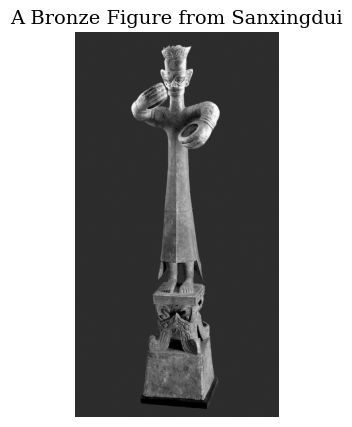

In [8]:
# Define a new image to compare with the existing ones
new_image_path2 = '../data/example_images/sanxingdui.jpeg'
new_image_label2 = 'A Bronze Figure from Sanxingdui' # Suppose this is a new artifact we just discovered

img_new2 = cv2.imread(new_image_path2, cv2.IMREAD_GRAYSCALE)
orb = cv2.ORB_create(nfeatures=500)
kp_new, desc_new = orb.detectAndCompute(img_new2, None)

if desc_new is not None and len(desc_new) > 0:
    words_new = kmeans.predict(desc_new)
    hist_new, _ = np.histogram(words_new, bins=np.arange(kmeans.n_clusters + 1))
else:
    hist_new = np.zeros(kmeans.n_clusters, dtype=int)
    
hist_new = hist_new.astype(float)
if hist_new.sum() > 0:
    hist_new /= hist_new.sum()

sims = cosine_similarity(histograms, hist_new.reshape(1, -1)).flatten()  

# Print the cosine similarity of the new image with existing images
print(f"\nCosine Similarity of '{new_image_label2}' with existing images:")
for i, label in enumerate(image_labels):
    print(f"{label} vs {new_image_label2}: {sims[i]:.3f}")

# Show the new image
plt.figure(figsize=(5, 5))
plt.imshow(img_new2, cmap='gray')
plt.title(f"{new_image_label2}")
plt.axis('off')
plt.show()

The results were exactly as we expected. The cosine similarity measured for different artistic styles, different poses and different angles of the Sanxingdui sculpture is significantly lower.

This provides us with a hint on how to build an automatic image-based classifier for art and artifacts of different genres, cultures, and textures. Although BoVW also has some obvious limitations (lack of spatial relationships, lack of ability to detect specific objects in complex images), the examples above demonstrate the fundamentals of computer vision, and with the help of more advanced techniques we can do much more in analyzing artwork based on digitized images.

### 2. Convolutions on Images

#### 2.1 What are convolutions?
Before diving into applying a **convolutional neural network**, let's first make an intuitive introduction to the concept **convolution**.

Imagine sliding a tiny image over an image as a filter to make the actual image appear the same as the filter. Convolution is the mathematical operation to achieve such an effect.

Below is one of such filters, or in professional term, a kernel, how do you think it will filter an image to make the image look like it?

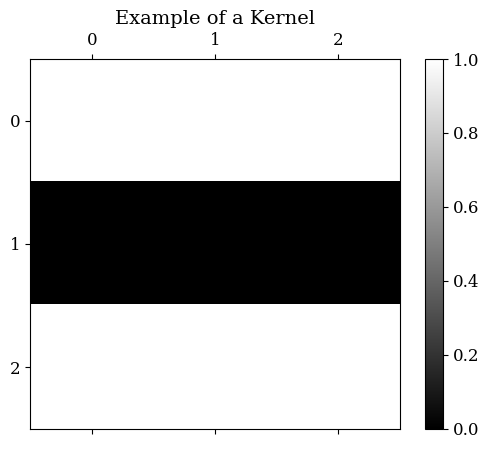

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Kernel
kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

# Map: 1 -> 1.0 (white), 0 -> 0.0 (black), -1 -> 1.0 (white)
display_kernel = np.where(kernel == 0, 0, 1)

fig, ax = plt.subplots()
cax = ax.matshow(display_kernel, cmap='gray', vmin=0, vmax=1)
plt.colorbar(cax)

# Annotate the kernel values

ax.set_title('Example of a Kernel')
plt.show()

This is how an actual image **Convolved** with the filter:

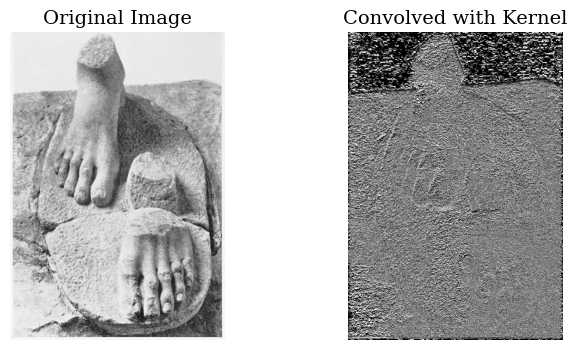

In [10]:
from scipy.ndimage import convolve
from PIL import Image

# Load the image as grayscale
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
image = Image.open(img_path).convert('L')
img_array = np.array(image)

# Define the horizontal edge detection kernel
kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

# Convolve the image with the kernel
convolved = convolve(img_array, kernel, mode='reflect')

# Display the original and convolved images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_array, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(convolved, cmap='gray')
ax[1].set_title("Convolved with Kernel")
ax[1].axis('off')
plt.show()

The above is just one example of a convolutional kernel that extracts horizontal edges in an image. In fact, there are many different kernels with different effects. For example, here is a filter that blurs all images:

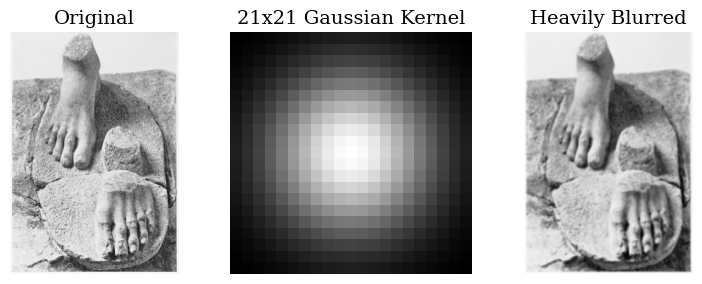

In [11]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

def gaussian_kernel(size=21, sigma=5):
    ax = np.linspace(-(size-1)//2, (size-1)//2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

kernel = gaussian_kernel(21, 5)
conv = convolve(img, kernel)
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(kernel, cmap='gray'); ax[1].set_title("21x21 Gaussian Kernel"); ax[1].axis('off')
ax[2].imshow(conv, cmap='gray'); ax[2].set_title("Heavily Blurred"); ax[2].axis('off')
plt.tight_layout(); plt.show()

Below is a kernel that preserves the input image as it is; it is also known as the identity kernel:

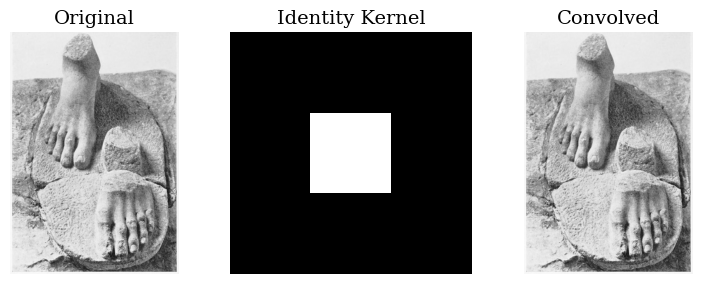

In [12]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

# Identity kernel (3x3)
kernel = np.zeros((3, 3))
kernel[1, 1] = 1

conv = convolve(img, kernel)
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(kernel, cmap='gray', vmin=0, vmax=1); ax[1].set_title("Identity Kernel"); ax[1].axis('off')
ax[2].imshow(conv, cmap='gray'); ax[2].set_title("Convolved"); ax[2].axis('off')
plt.tight_layout(); plt.show()

There is also a kernel that sharpens the images, known as the sharpening filter:

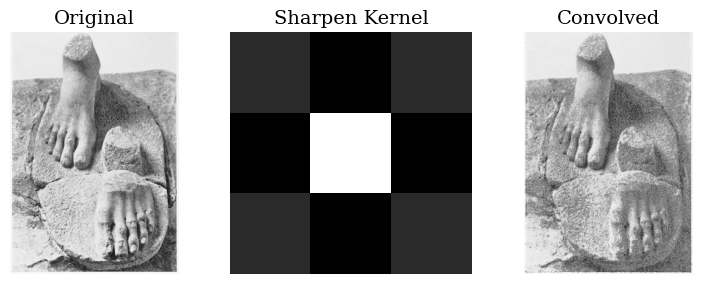

In [13]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

# Sharpen kernel
kernel = np.array([[ 0, -1,  0],
                   [-1,  5, -1],
                   [ 0, -1,  0]])

conv = convolve(img, kernel)
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(kernel, cmap='gray'); ax[1].set_title("Sharpen Kernel"); ax[1].axis('off')
ax[2].imshow(conv, cmap='gray'); ax[2].set_title("Convolved"); ax[2].axis('off')
plt.tight_layout(); plt.show()

Other than sharpening, there is even a filter to emboss the image:

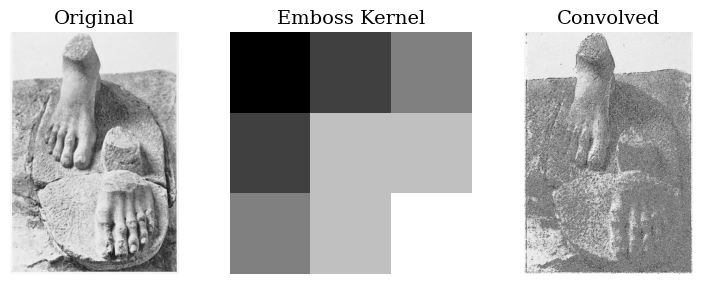

In [14]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

# Emboss kernel
kernel = np.array([[-2, -1, 0],
                   [-1,  1, 1],
                   [ 0,  1, 2]])

conv = convolve(img, kernel)
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(kernel, cmap='gray'); ax[1].set_title("Emboss Kernel"); ax[1].axis('off')
ax[2].imshow(conv, cmap='gray'); ax[2].set_title("Convolved"); ax[2].axis('off')
plt.tight_layout(); plt.show()

Other than only detecting vertical or horizontal edges, a filter named after Laplace was discovered to detect all edges:

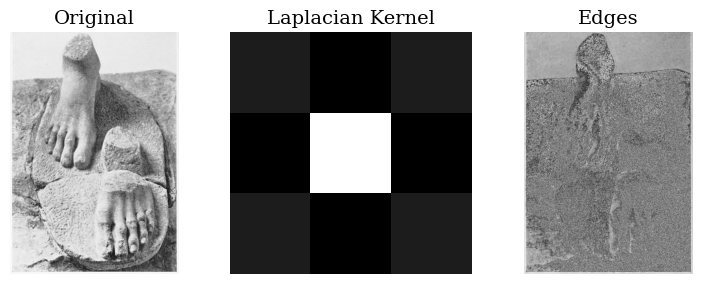

In [15]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

laplacian = np.array([[0,-1,0],[-1,8,-1],[0,-1,0]])
edge = convolve(img, laplacian)

fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off'
)
ax[1].imshow(laplacian, cmap='gray'); ax[1].set_title("Laplacian Kernel"); ax[1].axis('off')
ax[2].imshow(edge, cmap='gray'); ax[2].set_title("Edges"); ax[2].axis('off')
plt.tight_layout(); plt.show()

#### 2.2 What can Machine Learning do?

Over the years, people have discovered these tiny images or "kernels" or "filters". In machine learning, we discover or learn these potentially useful filters directly from the data, rather than through mathematical derivation. In a word, machine learning can "learn" the filters from data what would be useful for downstream tasks like classifying images or identifying things in an image.

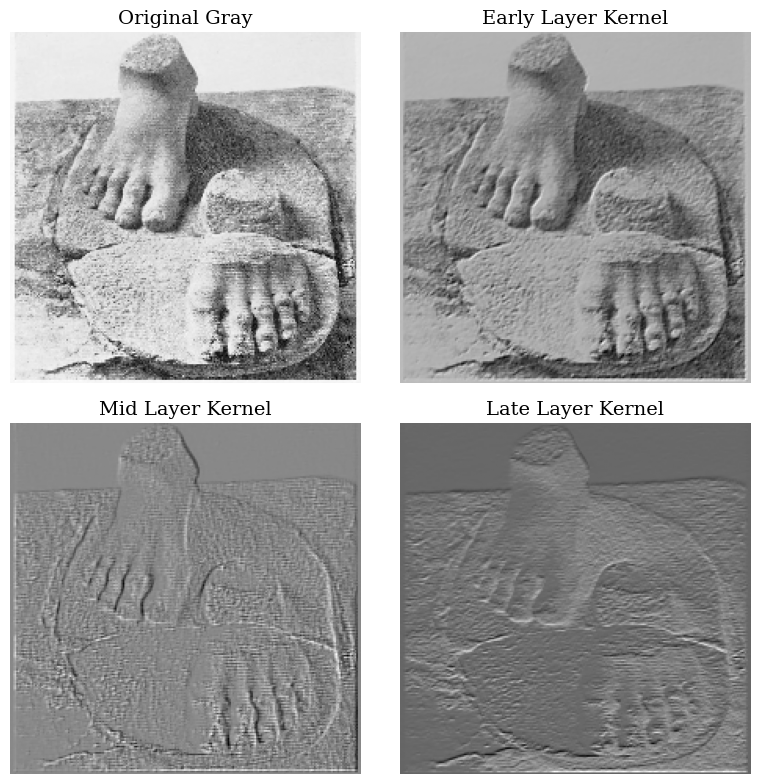

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1. Load a pretrained conv model (VGG16 without top)
model = VGG16(weights='imagenet', include_top=False)

# 2. Choose three conv layers: early, middle, late
early_layer = model.get_layer('block1_conv2')
mid_layer   = model.get_layer('block3_conv3')
late_layer  = model.get_layer('block5_conv3')

# 3. Extract one kernel from each layer
# Each kernel has shape (k, k, in_channels, out_channels)
kernel_early = early_layer.get_weights()[0][:, :, 0, 0]
kernel_mid   = mid_layer.get_weights()[0][:, :, 0, 0]
kernel_late  = late_layer.get_weights()[0][:, :, 0, 0]

# 4. Load and preprocess an image
def load_and_gray(path, target_size=(224,224)):
    img = image.load_img(path, target_size=target_size)
    img_arr = image.img_to_array(img)
    # convert to grayscale
    gray = cv2.cvtColor(img_arr.astype('uint8'), cv2.COLOR_RGB2GRAY)
    # normalize
    gray = gray.astype('float32') / 255.0
    return gray

img_path = '../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg'

gray = load_and_gray(img_path)

# 5. Convolve the image with each kernel
def apply_filter(img, kernel):
    # Flip kernel for convolution
    k = kernel.shape[0]
    # OpenCV uses correlation; flip kernel to perform convolution
    flipped = np.flipud(np.fliplr(kernel))
    filtered = cv2.filter2D(img, -1, flipped)
    return filtered

out_early = apply_filter(gray, kernel_early)
out_mid   = apply_filter(gray, kernel_mid)
out_late  = apply_filter(gray, kernel_late)

# 6. Visualize
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.title('Original Gray')
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Early Layer Kernel')
plt.imshow(out_early, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Mid Layer Kernel')
plt.imshow(out_mid, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Late Layer Kernel')
plt.imshow(out_late, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()  # In Colab this will display inline

Different parts of the model highlight different thing. The importnat thing to note is that no one wrote the filters themselves. The network learned that the features highlighted by these filters are useful.**We simply wrote the learning algorithm, then the model learned from data by itself.**

Typically, a model used for image classification can (on its own) learn filters to highlight things the model needs, such as edges and lines, and more importantly, in addition to these simple features, the model can learn filters to detect heads, eyes, ears, and other abstract concepts, and this is exactly how convolution makes it possible to detect, characterize, and categorize complex objects in complex images. In order to achieve these amazing features, we usually need to employ models such as **Convolutional Neural Networks**.

### 3. Data Exploration

#### 3.1 Exploring the Metadata

For the rest of the notebook, we will use a small selection of photographs from Richter's Kouroi (1942), which contain frontal shots of Kouroi with a full torso and recognizable facial features. We have also prepared a labeled metadata that shows information about which group and era these Kouroi belong to and what materials they are made of. We can begin by looking at some basic information from the metadata:

In [17]:
import pandas as pd

# Read in the metadata CSV file
# Note that we are only going to investigate a subset of the full dataset
df = pd.read_csv('../data/complete_sculpture_dataset_labeled.csv')

df = df.drop(columns = 'page')

print(df.head())

                    filename          group           era material
0  page188_img01_photo13.jpg  SOUNION GROUP  615 - 590 BC   Marble
1   page202_img01_photo3.jpg  SOUNION GROUP  615 - 590 BC   Marble
2   page202_img01_photo4.jpg  SOUNION GROUP  615 - 590 BC   Marble
3   page205_img01_photo4.jpg  SOUNION GROUP  615 - 590 BC   Marble
4  page211_img01_photo12.jpg  SOUNION GROUP  615 - 590 BC    Other


In [18]:
print("Information of the dataset:")
print(f"Number of images: {df.shape[0]}")
print(f"Number of distinct eras: {df['era'].nunique()}")
print(f"Number of distinct materials: {df['material'].nunique()}")

Information of the dataset:
Number of images: 62
Number of distinct eras: 7
Number of distinct materials: 3


We can also see the distribution of each label by plotting histograms:

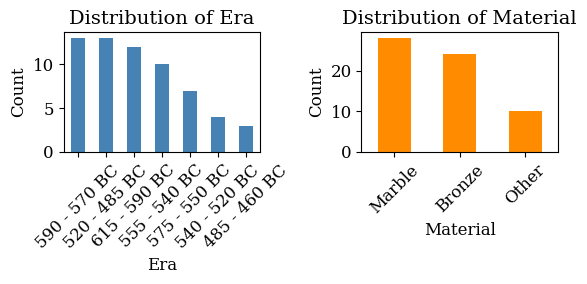

In [19]:
def bar_plot(df, column1, column2):
    # Calculate counts of each value in the specified columns
    label_counts1 = df[column1].value_counts()
    label_counts2 = df[column2].value_counts()

    # Create a figure with a fixed size
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Plot the bar chart
    label_counts1.plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title(f'Distribution of {column1.capitalize()}')
    axes[0].set_xlabel(column1.capitalize())
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    label_counts2.plot(kind='bar', ax=axes[1], color='darkorange')
    axes[1].set_title(f'Distribution of {column2.capitalize()}')
    axes[1].set_xlabel(column2.capitalize())
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot the distribution of labels in the dataset
bar_plot(df, 'era', 'material')

#### 3.2 Exploring the Images

To get a direct idea of the general characteristics of this subset of photographs, we read the photographs from the image directory and show the first 4 images in this dataset.

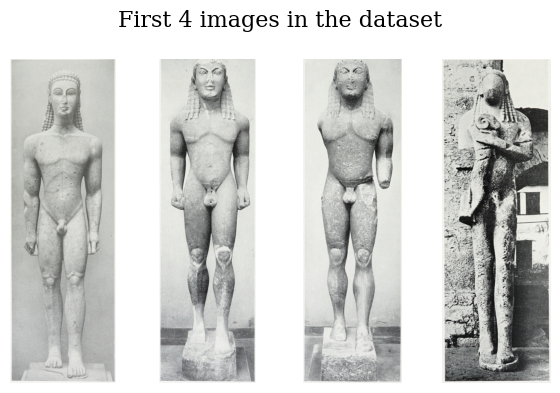

In [20]:
# Read in the images as a list 
from pathlib import Path

data_dir = Path("../data/richter_kouroi_complete_front_only")
image_paths = sorted(data_dir.glob("*.jpg"))

images = []
for p in image_paths:
    img = Image.open(p).convert("RGB")   # ensure 3‑channel
    img_arr = np.array(img)
    images.append(img_arr)
    
fig, axes = plt.subplots(1, 4, figsize=(6, 4))
for ax, img in zip(axes, images[:4]):
    ax.imshow(img)
    ax.axis("off")
plt.suptitle("First 4 images in the dataset")
plt.tight_layout()
plt.show()

### 4. Image Embedding Using ConvNeXt V2

#### 4.1 CNN and Models See Images

What we'll do next is we will bring in ConvNeXt V2, it is a CNN model trained on millions of images based on ImageNet. 

I'm sure everyone has used some **Large Language Models (LLMs)** and gotten a feel for how these models mimic the way humans think. This imitation of the human way of thinking comes from **Artificial Neural Networks (ANN)**. Just as **LLMs** process and generate natural language, **CNN models** process visual images, examining the features in those images through **convolutional layers** and generating their own digital representations of the images. 

Here, we will create a visualization that shows the early, middle, and late feature layers of the 4 images after convolution, what commonality and difference did you notice from the extracted features in these layers?

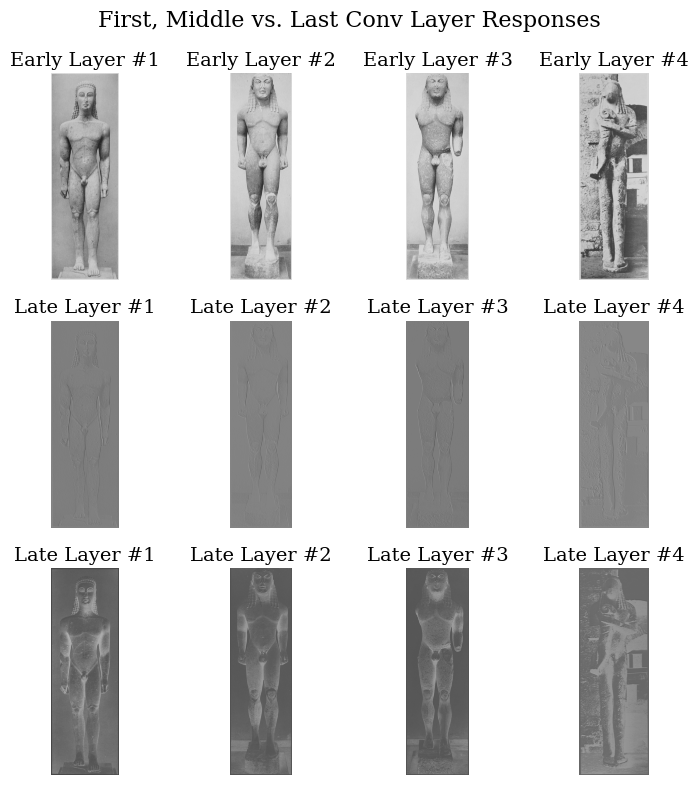

In [21]:
model = VGG16(weights='imagenet', include_top=False)

# Grab kernels from the first and last conv layers
early_layer = model.get_layer('block1_conv2')
mid_layer = model.get_layer('block3_conv3')
late_layer  = model.get_layer('block5_conv3')

# choose the (0,0) filter for each
kernel_early = early_layer.get_weights()[0][:, :, 0, 0]
kernel_mid  = mid_layer.get_weights()[0][:, :, 0, 0]
kernel_late  = late_layer.get_weights()[0][:, :, 0, 0]

# Convolution helper (flip kernel for true conv)
def apply_filter(img, kernel):
    flipped = np.flipud(np.fliplr(kernel))
    return cv2.filter2D(img, -1, flipped)

fig, axes = plt.subplots(3, 4, figsize=(8, 8))

for col, img in enumerate(images[:4]):
    gray = (
        cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
          .astype('float32') / 255.0
    )
    out_early = apply_filter(gray, kernel_early)
    out_early = (out_early - out_early.min()) / (out_early.max() - out_early.min())

    out_mid = apply_filter(gray, kernel_mid)
    out_mid = (out_mid - out_mid.min()) / (out_mid.max() - out_mid.min())
    
    out_late = apply_filter(gray, kernel_late)
    out_late = (out_late - out_late.min()) / (out_late.max() - out_late.min())

    # plot
    axes[0, col].imshow(out_early, cmap='gray')
    axes[0, col].set_title(f'Early Layer #{col+1}')
    axes[0, col].axis('off')

    axes[1, col].imshow(out_mid, cmap='gray')
    axes[1, col].set_title(f'Late Layer #{col+1}')
    axes[1, col].axis('off')

    axes[2, col].imshow(out_late, cmap='gray')
    axes[2, col].set_title(f'Late Layer #{col+1}')
    axes[2, col].axis('off')

fig.suptitle('First, Middle vs. Last Conv Layer Responses', fontsize=16)
plt.tight_layout()
plt.show()

#### 4.2 Creating Image Embeddings

**Image embedding** is a process where images are transformed into numerical representations, specifically, lists of numbers that carry informations about the images. While this sounds somewhat similar to the idea of visual words, they are not the same. Think of BoVW as counting how many times specific words appear in a book without caring about grammar or sentence structure, this can identify simple patterns, but cannot summarize the big picture of the book. Image embeddings, on the other hand, are like reading the entire book and summarizing its meaning in a well crafted passage, they capture the bigger picture, context, and nuance.

We can build a vocabulary of visual words quite easily, but creating image embeddings usually require using deep neural networks pretrained on millions of images. These networks process the entire image and learn hierarchical, abstract features that are more semantically meaningful.  

Here, we will load the pre-trained ConvNeXt V2 model, pass the image folder to generate embeddings, and save the embeddings in a grid of numbers.


In [22]:
# Read in the pre-trained ConvNeXtV2 model
from transformers import AutoImageProcessor
from transformers import ConvNextV2Model
from torchvision.models import convnext_base,  ConvNeXt_Base_Weights
import torch
from tqdm.notebook import tqdm

# Load the pre-trained ConvNeXtV2 model and image processor
processor = AutoImageProcessor.from_pretrained("facebook/convnextv2-base-22k-224") 

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNextV2Model.from_pretrained("facebook/convnextv2-base-22k-224")

# Move the model to the appropriate device (GPU or CPU)
_ = model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [23]:
batch_size = 16
embeddings = []
valid_filenames = []

image_directory = "../data/richter_kouroi_complete_front_only"

filenames = df['filename'].tolist()

for i in tqdm(range(0, len(filenames), batch_size), desc="Processing Images in Batches"):
    batch_filenames = filenames[i : i + batch_size]
    images = []
    for filename in batch_filenames:
        path = os.path.join(image_directory, filename)
        try:
            img = Image.open(path).convert("RGB")
            images.append(img)
        except FileNotFoundError:
            print(f"Missing: {path}")
        except Exception as e:
            print(f"Error with {filename}: {e}")

    if not images:
        continue

    # Prepare inputs
    inputs = processor(images=images, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    # Forward through feature extractor
    with torch.no_grad():
        outputs = model(pixel_values)   
    # Global average pool
    if isinstance(outputs, torch.Tensor):
        hidden = outputs           
    else:
        hidden = outputs.last_hidden_state 

    batch_emb = hidden.mean(dim=(2, 3)).cpu().numpy()

    embeddings.extend(batch_emb)   
    
embeddings = np.stack(embeddings, axis=0) 

np.save('../data/embeddings/convnextv2_image_embeddings.npy', embeddings)

Processing Images in Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
print(embeddings)

embeddings.shape

[[-0.42546895 -4.1213956  -2.0160959  ... -2.990931    4.8743505
  -0.30853495]
 [ 0.5560602  -2.8647199  -2.922471   ... -1.7647432   4.883092
  -0.54576755]
 [-1.2865281  -1.4737651  -3.792193   ...  0.15527564  1.6415085
  -1.8216568 ]
 ...
 [-2.3245587  -3.1991036  -3.004582   ... -0.40073264 -0.21882926
   0.5936357 ]
 [-0.5283613  -4.433328   -3.7179348  ... -3.0150347   2.0326397
  -1.6606904 ]
 [ 0.31188568 -2.7383516  -3.1720133  ... -3.6925333   3.5139418
   1.2292051 ]]


(62, 1024)

We printed the embedded results above to see what they look like, and we also displayed the shape of the grid. As you can see, it contains 62 rows representing the 62 images in the dataset, and each row has 1024 numbers representing all the information extracted from each image. From now on, we will use this embedded data instead of the original image data.

### 5. Analysis of Image Embeddings
#### 5.1 Principal Component Analysis

1024 is way too many numbers for us to examine and understand with our brains. So, we use something techniques called **dimensionality reduction** to squish the data down to just 2 or 3 dimensions, making it easy to visualize in 2D. 

**Principal Component Analysis (PCA)** is one of such techniques, it is essentially finding the two or three major axes through our huge data along which the data has the most variations. By PCA we decompose our data with 1024 dimensions (number of cells in each row) to 2 dimensions and represent each image as a point on our scatterplots. We then color the data with "era" and "material" respectively. Here, we will use plotly to create interactive visualizations, feel free to play with it and discuss what pattern did you notice?

In [25]:
from sklearn.decomposition import PCA
import plotly.express as px

# load embeddings and metadata
embeddings = np.load('../data/embeddings/convnextv2_image_embeddings.npy')
df = pd.read_csv('../data/complete_sculpture_dataset_labeled.csv')   # make sure this has at least an 'era' column

# PCA to 2 components
pca = PCA(n_components=2)
pc2 = pca.fit_transform(embeddings)

# build DataFrame
pc_df = pd.DataFrame(pc2, columns=['PC1','PC2'])
pc_df['filename'] = df['filename'].values
pc_df['era'] = df['era'].values

# interactive scatter
fig = px.scatter(
        pc_df,
        x='PC1',
        y='PC2',
        color='era',
        hover_data=('filename',), # Show filename when hovering
        title='Interactive PCA of Image Embeddings Colored by Era',
        width=700, height=500
    )

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [26]:
pc_df['material'] = df['material'].values

fig = px.scatter(
        pc_df,
        x='PC1',
        y='PC2',
        color='material',
        hover_data=('filename',), # Show filename when hovering
        title='Interactive PCA of Image Embeddings Colored by Material',
        width=700, height=500
    )

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Did you see any clear patterns of distributions by looking at the visualizations above? How can you interpret the results? 

### 6. Classification of Kouroi 

**Archaeological classification** has always been an important issue in archaeology and artifact research. This problem is especially challenging when faced with a large amount of artifact data, or when faced with new artifacts with insufficient information. With the development of machine learning and image recognition technology, the use of computer technology to assist classification has become a trend in the new era of information archaeology. In this section, we would like to provide an example of classifying Kouroi by visual element for your reference.

#### 6.1 Traditional Approach

In addition to observing how the labels are clustered based on the embeddings, we can train classifiers to categorize objects into appropriate labels based on the image embeddings directly. A traditional approach is through a technique called **logistic regression**. 

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = embeddings
y1 = df['era'].tolist()
y2 = df['material'].tolist()

y1 = np.array(y1)
y2 = np.array(y2)

Note that here we use image embeddings and labels as training data and test data respectively, this is because we want to evaluate the effectiveness of the classifier when dealing with unseen data. After training the classifier for eras, we use it to predict the labels of the test data and compare the results with the real labels. The report is printed below:

In [28]:
# Perform the classification of eras
# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.3, random_state=42, stratify=y1)

# Create a logistic regression model
clf1 = LogisticRegression(max_iter=1000, random_state=42)

clf1.fit(X_train1, y_train1)

y_pred1 = clf1.predict(X_test1)

# Calculate classification metrics
classification_report1 = metrics.classification_report(y_test1, y_pred1, zero_division=0)

# Print the classification report 
print("Classification Report for Eras:")
print(classification_report1)

Classification Report for Eras:
              precision    recall  f1-score   support

485 - 460 BC       0.00      0.00      0.00         1
520 - 485 BC       0.40      0.50      0.44         4
540 - 520 BC       0.00      0.00      0.00         1
555 - 540 BC       0.33      0.67      0.44         3
575 - 550 BC       0.00      0.00      0.00         2
590 - 570 BC       0.00      0.00      0.00         4
615 - 590 BC       1.00      0.25      0.40         4

    accuracy                           0.26        19
   macro avg       0.25      0.20      0.18        19
weighted avg       0.35      0.26      0.25        19



The key metrics we especially care about here is the accuracy of our classifier, it is defined by

$$
\text{Accuracy} = \frac{\text{True Predictions}}{\text{True Predictions} + \text{Flase Predictions}}
$$

It reflects the proportion of true predictions out of all predictions made using the classifier. However, as shown above in the report, the accuracy of predicting era based on image embedding is not satisfactory. Still, we can visualize the decision boundary of this classifier on our 2D PCA of image embeddings to see what went wrong:

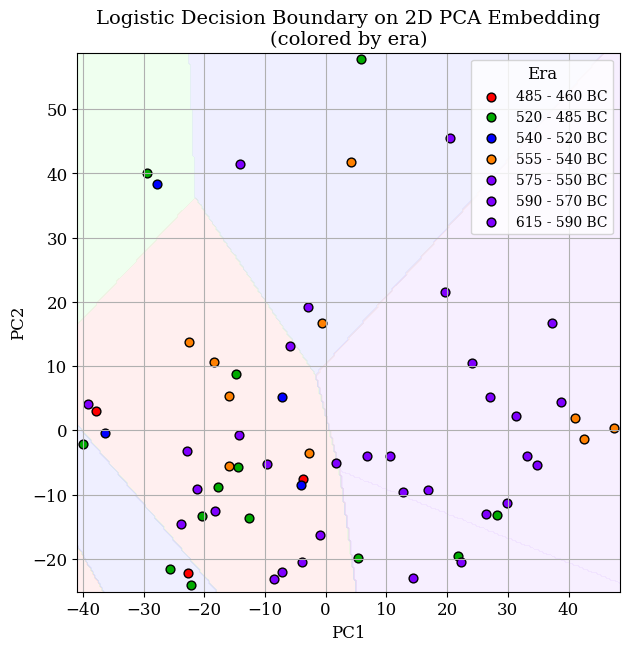

In [29]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# Prepare your 2D data + labels
X_pca = pc_df[['PC1','PC2']].values
y_era = pc_df['era'].values

# Encode eras as integers
le = LabelEncoder()
y_enc = le.fit_transform(y_era)

# Train the logistic on the encoded labels
clf_2d = LogisticRegression(max_iter=1000, random_state=42)
clf_2d.fit(X_pca, y_enc)

# Build a mesh grid over the plotting area
x_min, x_max = X_pca[:,0].min() - 1, X_pca[:,0].max() + 1
y_min, y_max = X_pca[:,1].min() - 1, X_pca[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

# Predict integer labels on the mesh
Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot
plt.figure(figsize=(7,7))

# light colors for regions
cmap_light = ListedColormap(['#FFCCCC','#CCFFCC','#CCCCFF','#FFE5CC','#E5CCFF'][:len(le.classes_)])
# bold colors for points
cmap_bold  = ListedColormap(['#FF0000','#00AA00','#0000FF','#FF8000','#8000FF'][:len(le.classes_)])

# contourf needs numeric Z
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

# scatter original points, mapping back to string labels in the legend
for class_int, era_label in enumerate(le.classes_):
    mask = (y_enc == class_int)
    plt.scatter(
        X_pca[mask,0], X_pca[mask,1],
        color=cmap_bold(class_int),
        label=era_label,
        edgecolor='k', s=40
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Logistic Decision Boundary on 2D PCA Embedding\n(colored by era)')
plt.legend(title='Era')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.show()

What can you say about this decision boundary?

Similarly, we can use the same approach to classify material of Kouroi. We first perform a train-test split, then train the classifier, use the trained classifier to predict the labels of the test set, and print out the classification report for quality evaluation.

In [30]:
# Perform the classification of materials
# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.3, random_state=42, stratify=y2)

# Create a logistic regression model
clf2 = LogisticRegression(max_iter=1000, random_state=42)

clf2.fit(X_train2, y_train2)

y_pred2 = clf2.predict(X_test2)

# Calculate classification metrics
classification_report2 = metrics.classification_report(y_test2, y_pred2, zero_division=0)

# Print the classification report
print("Classification Report for Materials:")
print(classification_report2)

Classification Report for Materials:
              precision    recall  f1-score   support

      Bronze       0.88      1.00      0.93         7
      Marble       1.00      1.00      1.00         9
       Other       1.00      0.67      0.80         3

    accuracy                           0.95        19
   macro avg       0.96      0.89      0.91        19
weighted avg       0.95      0.95      0.94        19



As you can see, the accuracy is much higher now, but does that mean the classifier is good? You may have noticed that bronze and marble are classified almost perfectly, but other materials are not. This means that the classifier, while having a high accuracy, may have low precision or recall, as defined below:

- **Precision**: The ratio of the number of true positives to the number of positive predictions. Precision tells us how often the model predicts correctly. 
- **Recall**: The ratio of the number of true positives to the number of actual positives. Recall answers the question, "What percentage of positive results did we correctly predict?"

We can also visualize the decision boundary on the 2D PCA of materials

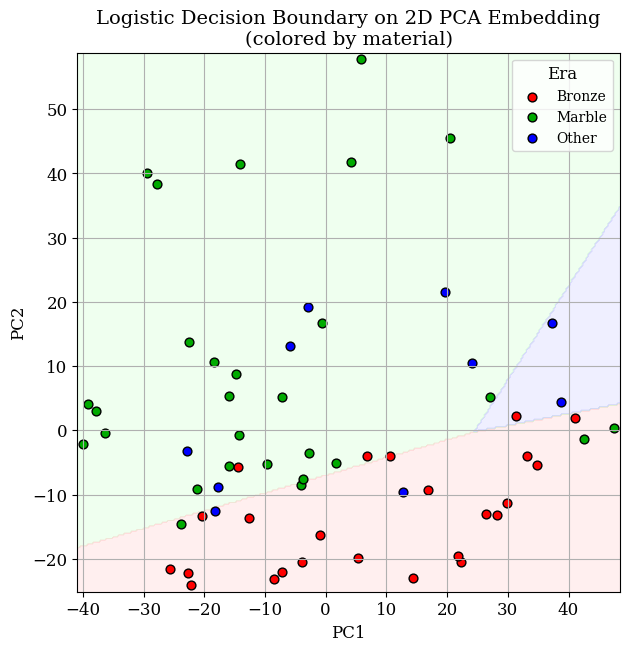

In [31]:
# Prepare 2D data + labels
X_pca = pc_df[['PC1','PC2']].values
y_era = pc_df['material'].values

# Encode eras as integers
le = LabelEncoder()
y_enc = le.fit_transform(y_era)

# Train the logistic on the encoded labels
clf_2d = LogisticRegression(max_iter=1000, random_state=42)
clf_2d.fit(X_pca, y_enc)

# Build a mesh grid over the plotting area
x_min, x_max = X_pca[:,0].min() - 1, X_pca[:,0].max() + 1
y_min, y_max = X_pca[:,1].min() - 1, X_pca[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

# Predict integer labels on the mesh
Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot
plt.figure(figsize=(7,7))

# light colors for regions
cmap_light = ListedColormap(['#FFCCCC','#CCFFCC','#CCCCFF','#FFE5CC','#E5CCFF'][:len(le.classes_)])
# bold colors for points
cmap_bold  = ListedColormap(['#FF0000','#00AA00','#0000FF','#FF8000','#8000FF'][:len(le.classes_)])

# contourf needs numeric Z
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

# scatter original points, mapping back to string labels in the legend
for class_int, era_label in enumerate(le.classes_):
    mask = (y_enc == class_int)
    plt.scatter(
        X_pca[mask,0], X_pca[mask,1],
        color=cmap_bold(class_int),
        label=era_label,
        edgecolor='k', s=40
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Logistic Decision Boundary on 2D PCA Embedding\n(colored by material)')
plt.legend(title='Era')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.show()

Now, going back to the classification reports shown above, do you think the classifier trained on era is a good chronological classifier? What about materials? 

#### 6.2 CNN Classification of Materials

The last classifier we're going to visit today is a neural network classifier, using a **Multi-layer Perceptron (MLP)** network architecture, which means we're going to add a classification layer to the ConvNeXt V2 model to classify the material. All the model does here is act as a **backbone** to observe and extract features of interest in the input image. The MLP process, on the other hand, can be visualized as a number of experts examining different features on an image, then discussing them with each other, and finally voting to reach a final conclusion.

We begin by creating the data loader and load the Kouroi data directly from the folder:

In [32]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Map the materials to integers

MAT2IDX = {
    'Marble': 0,
    'Bronze': 1,
    'Other': 2
}

# Create a custom dataset class for the Kouroi dataset
class KouroiDataset(Dataset):
    def __init__(self, img_dir, processor, mat2idx):
        self.df = df
        self.img_dir = image_directory
        self.processor = processor
        self.mat2idx = MAT2IDX

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row.filename)).convert("RGB")
        # turn to model inputs
        inputs = self.processor(images=img, return_tensors="pt")
        # remove batch dim
        for k,v in inputs.items():
            inputs[k] = v.squeeze(0)
        label = self.mat2idx[row.material]
        return inputs, label

In [33]:
# Initialize the dataset and dataloader
dataset = KouroiDataset(image_directory, processor, MAT2IDX)
loader  = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

As mentioned above, here we freeze the model so that training does not change the way it understands the input image.

In [34]:
# Build the model with convnextv2 as the backbone and a linear layer for classification
class Classifier(nn.Module):
    def __init__(self, backbone_name, num_classes):
        super().__init__()
        # Load the ConvNeXtV2 backbone correctly and freeze it
        self.backbone = ConvNextV2Model.from_pretrained(
            backbone_name,
            output_hidden_states=False,
            output_attentions=False
        )
        for p in self.backbone.parameters():
            p.requires_grad = False

        embed_dim = self.backbone.config.hidden_sizes[-1]

        # Build a simple 2-layer MLP head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, pixel_values):
        # Forward through the frozen backbone
        outputs = self.backbone(pixel_values=pixel_values)
        x = outputs.pooler_output

        # Classification head
        logits = self.head(x)
        return logits

# Instantiate and move to device
model = Classifier(
    backbone_name="facebook/convnextv2-base-22k-224",
    num_classes=len(MAT2IDX)
).to(device)

Here, after setting up the new model, we will define the training loop and train the model. Please note that this process may take some time, especially when running on devices without a GPU.

In [35]:
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=1e-4, weight_decay=0.01)
epochs = 10  

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc=f"Epoch {epoch}/{epochs}"):
        inputs, labels = batch
        # move to device
        inputs = {k:v.to(device) for k,v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(**inputs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / len(dataset)
    print(f" Epoch {epoch} avg loss: {avg_loss:.4f}")

Epoch 1/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 1 avg loss: 1.1041


Epoch 2/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 2 avg loss: 0.8782


Epoch 3/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 3 avg loss: 0.8020


Epoch 4/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 4 avg loss: 0.7322


Epoch 5/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 5 avg loss: 0.6264


Epoch 6/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 6 avg loss: 0.5765


Epoch 7/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 7 avg loss: 0.5060


Epoch 8/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 8 avg loss: 0.4739


Epoch 9/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 9 avg loss: 0.4087


Epoch 10/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 10 avg loss: 0.3763


After training, we set the model to evaluation mode and assessed the classification quality by printing the confusion matrix and classification report. It is clear that the accuracy does improve with the MLP architecture. However, we still lacked samples of materials other than bronze and marble, which undoubtedly harmed the quality of our training. 

In [36]:
# Run one pass over your data in eval mode
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in loader:
        if inputs is None: continue
        inputs = {k:v.to(device) for k,v in inputs.items()}
        logits = model(**inputs)
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.numpy())

# Print the classification report
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=list(MAT2IDX.keys()), zero_division=0)
print("Classification Report for Materials:")
print(report)

Classification Report for Materials:
              precision    recall  f1-score   support

      Marble       0.88      1.00      0.93        28
      Bronze       1.00      0.96      0.98        24
       Other       1.00      0.70      0.82        10

    accuracy                           0.94        62
   macro avg       0.96      0.89      0.91        62
weighted avg       0.94      0.94      0.93        62



Did you notice anything different in the result?

#### 6.3 Example: Predicting the Material of Unseen Kouroi Photos

Now, let's imagine a scenario where we find a new Kouros, but we are not sure what it is made of, and we want to use our trained classifier to classify it based on its image features.

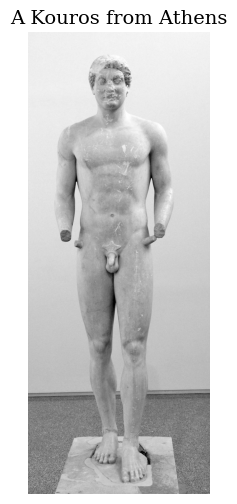

In [37]:
# Define a new image to compare with the existing ones
new_artifact_path = '../data/NAMA_3938_Aristodikos_Kouros.jpeg'
new_artifact_label = 'A Kouros from Athens' # Suppose this is a new artifact we just discovered

art_new = cv2.imread(new_artifact_path, cv2.IMREAD_GRAYSCALE)

# Show the new image
plt.figure(figsize=(6, 6))
plt.imshow(art_new, cmap='gray')
plt.title(f"{new_artifact_label}")
plt.axis('off')
plt.show()

We pass it into our trained CNN classifier and see how it would be classified:

In [38]:
from PIL import Image
import torch
from torchvision import transforms
# Resize the model to an appropriate size
preprocess = transforms.Compose([
    transforms.Resize(256),                
    transforms.CenterCrop(224),            
    transforms.ToTensor(),
    transforms.Normalize(                   
        mean=[0.485, 0.456, 0.406],
        std= [0.229, 0.224, 0.225]
    ),
])

idx2mat = {idx: mat for mat, idx in MAT2IDX.items()}

def predict_image(image_path, model, device):
    # Load
    img = Image.open(image_path).convert("RGB")
    # Preprocess
    x = preprocess(img)
    x = x.unsqueeze(0).to(device)
    # Inference
    model.eval()
    with torch.no_grad():
        logits = model(**{"pixel_values": x}      
                       if isinstance(x, torch.Tensor) else x)
        pred_idx = logits.argmax(dim=1).item()

    return idx2mat[pred_idx]

model.to(device)

predicted_material = predict_image(new_artifact_path, model, device)
print("Predicted Material:", predicted_material)

Predicted Material: Marble


Do you think the prediction is correct? 

#### 6.4 Additional Note on Fine-tuning

What we didn't include here is an advanced application called fine-tuning. **Fine-tuning** refers to the process of taking a pre-trained model (like ConvNeXt V2) and continuing its training on your specific dataset, allowing the model to adapt its learned features to better suit your task. Why we did not cover fine-tuning because it requires more computational resources, careful hyperparameter tuning, and a larger dataset to avoid overfitting. Additionally, fine-tuning can be time-consuming and is often not practical in an introductory or resource-limited setting.

However, fine-tuning has the potential to significantly improve classification quality. By allowing the model to update its internal representations based on the unique characteristics of your images, it can learn more relevant features for distinguishing between subtle differences in style, era, or material. For research or production applications with sufficient data and compute, fine-tuning is a powerful next step to achieve higher accuracy and more robust results.

### 7. Conclusion

Through this notebook, you've taken a journey with the example of Richter's Kouroi from the basics of how computers "see" images to advanced techniques for analyzing and classifying images. You've explored how simple pixel values can be transformed into powerful representations using convolution, image embeddings, and neural networks. Along the way, you learned to visualize, cluster, and classify artworks...... these are all skills that are at the heart of modern computer vision.

Remember, the tools and concepts you've practiced here are not just limited to art history or archaeology: they are widely used in fields ranging from medicine to astronomy, and beyond. As you continue your studies, keep experimenting, stay curious, and don't be afraid to explore new datasets or try more advanced models. The intersection of technology and the humanities is full of exciting possibilities, and your creativity is the key to unlocking them.

Congratulations on completing this exploration, and we hope you feel inspired to keep learning and discovering the field of Machine Learning!

### Key Takeaways

- There are multiple different ways for computers to represent and understand content in images, including **intensity histograms**, **BoVW distribution** and **image embeddings**.
- **Convolution** is a common technique to process and extract different features in input images. 
- **Convolutional Neural Networks (CNN)** are trained models that mimic the way people view images and understand them through convolutional layers.
- **Image embeddings** produced by a pretrained CNN map each kouros image into a high‑dimensional feature space. We can then apply **dimensionality‑reduction techniques** such as **Principal Component Analysis** to visualize clusters among different archaic sculptures.
- For formal classification of kouroi, such as distinguishing groups/eras or identifying materials, both **logistic regression** and **neural-network classification** provide robust methods to assign style labels based on extracted image features, but we should always be aware of issues such as **underfitting** and **overfitting**.
- Different models may yield different results for image embedding, and sometimes the features recognized from an image are not exactly what we want. We should always be cautious about our results.

### Glossary

- **Computer Vision**: Computer Vision is a field of artificial intelligence that enables computers to "see" and interpret images and videos, mimicking human vision.
- **Convolution**: In the context of Computer Vision, Convolution is an operation that applies a filter (kernel) to an image, transforming it in a way that enhances certain features or extracts useful information. It is like using a brush to color a painting or a pen to sketch a line art.
- **Convolutional Neural Network (CNN)**: Convolutional Neural Network is a type of feedforward neural network that learns features via filter (or kernel) optimization. It is distinguished from other neural networks by its superior performance with image, speech or audio signal inputs.
- **Image Embedding**: Image Embedding is a process where images are transformed into numerical representations, called vectors, that capture the semantic meaning of the image. 
- **Principal Component Analysis (PCA)**: Principal Component Analysis is a statistical technique that simplifies complex data sets by reducing the number of variables while retaining key information. It does so by finding the major axes where the data sets vary the most.
- **Logistic Regression**: Logistic Regression is a statistical model used for binary or multiclass classification tasks. It estimates the probability that an input belongs to a particular class by applying the logistic (sigmoid) function to a weighted sum of the input features, making it well-suited for problems where outputs are discrete categories.
- **Multilayer Perceptron (MLP)**: A Multilayer Perceptron is a class of feedforward artificial neural network composed of an input layer, one or more hidden layers of nonlinear activation units, and an output layer. It learns complex patterns by adjusting the weights of connections through backpropagation and is versatile for both classification and regression tasks.
- **Underfitting**: Underfitting in machine learning occurs when a model is too simple to capture the underlying patterns in the training data.
- **Overfitting**: Overfitting in machine learning occurs when a model learns the training data too well, including its noise and random fluctuations, leading to poor performance on new, unseen data.


### Appendix A: Image Data Collection and Preprocessing from `.pdf` Files

This part provides a brief overview of how the data was collected and preprocessed for the analysis, typically how we cropped the images and prepared the metadata.

We used the following python script to convert a scanned pdf of Richter (1942) to image files in `.jpg` format.

```python
import fitz  

# Change the filename here if you want to reuse the script for your own project
doc = fitz.open("kouroiarchaicgre0000rich_1.pdf") 

import os
out_dir = "extracted_images"
os.makedirs(out_dir, exist_ok=True)

# Iterate pages
for page_index in range(len(doc)):
    page = doc[page_index]
    image_list = page.get_images(full=True)  # get all images on this page

    # Skip pages without images
    if not image_list:
        continue

    # Extract each image
    for img_index, img_info in enumerate(image_list, start=1):
        xref = img_info[0]                   
        base_image = doc.extract_image(xref)  
        image_bytes = base_image["image"]     
        image_ext   = base_image["ext"]      

        # Write to file
        out_path = os.path.join(
            out_dir,
            f"page{page_index+1:03d}_img{img_index:02d}.{image_ext}"
        )
        with open(out_path, "wb") as f:
            f.write(image_bytes)

print(f"Saved all images to {out_dir}")
```

The following script cropped the photos by applying convolution.

```python
import cv2
import glob
import os

# Folder containing your page images
input_folder = "extracted_images"
output_folder = "cropped_photos"
os.makedirs(output_folder, exist_ok=True)

def extract_photos_from_page(image_path, min_area=5000):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Blur and threshold to get binary image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)
    
    # Dilate to merge photo regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    dilated = cv2.dilate(thresh, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    crops = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        # Filter by area to remove small artifacts
        if area > min_area:
            crop = img[y:y+h, x:x+w]
            crops.append((crop, (x, y, w, h)))
    return crops

# Process all pages
for img_path in glob.glob(os.path.join(input_folder, "*.*")):
    base = os.path.splitext(os.path.basename(img_path))[0]
    photos = extract_photos_from_page(img_path)
    for idx, (crop, (x, y, w, h)) in enumerate(photos, start=1):
        out_file = os.path.join(output_folder, f"{base}_photo{idx}.jpg")
        cv2.imwrite(out_file, crop)

print(f"Saved all images at {output_folder}")
```
The following script employed `tesseract` OCR engine to detect pure text images and filter out photos of Kouros. You may want to visit the GitHub repository <https://github.com/tesseract-ocr/tesseract> to see how to install and setup appropriately.

```python
import os
import shutil
from PIL import Image
import pytesseract
# Ensure you have Tesseract installed and pytesseract configured correctly.
# On Windows, you might need:
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Folders
input_folder = "cropped_photos"
text_folder = "text_crops"
photo_folder = "filtered_photos"
os.makedirs(text_folder, exist_ok=True)
os.makedirs(photo_folder, exist_ok=True)

# Threshold for text length to consider as "text-only"
# You can also adjust this threshold based on your specific needs.
TEXT_CHAR_THRESHOLD = 2 # Be careful with this threshold, do remember to check the results manually


for filename in os.listdir(input_folder):
    path = os.path.join(input_folder, filename)
    img = Image.open(path)

    # Perform OCR to extract text
    extracted_text = pytesseract.image_to_string(img)

    # Classify based on length of extracted text
    if len(extracted_text.strip()) >= TEXT_CHAR_THRESHOLD:
        dest = os.path.join(text_folder, filename)
    else:
        dest = os.path.join(photo_folder, filename)

    shutil.move(path, dest)
    print(f"Moved {filename} -> {os.path.basename(dest)}")

print("Filtering complete")
```
This script creates a `.csv` file for mannual labelling.

```python
import os, re
import pandas as pd

# Scan your filtered_photos folder
records = []

# Updated regex to match "page<number>_img<number>_photo<number>.<ext>"
pattern = re.compile(r"page(\d+)_img\d+_photo(\d+)\.(?:png|jpe?g)", re.IGNORECASE)

for fn in os.listdir("richter_kouroi_head_front_only"):
    m = pattern.match(fn)
    if not m:
        continue
    page = int(m.group(1))
    photo_idx = int(m.group(2))
    records.append({
        "filename": fn,
        "page": page,
        "group": "",    # blank for manual entry
        "era": "",  # blank for manual entry
        "material": ""  # blank for manual entry
    })

# Build DataFrame
df = pd.DataFrame(records)

df.sort_values(["page", "filename"], inplace=True)

# Save out to CSV for manual labeling
df.to_csv("label_template.csv", index=False)
```
You can try out the scripts with your interested pdf files yourself by running them in a python environment.

### Appendix B: The Risk of Underfitting and Overfitting

In the context of machine learning, two common pitfalls are **underfitting** and **overfitting**. 

**Underfitting** occurs when a model is too simple to capture the underlying patterns in the data, resulting in poor performance on both the training and test sets. This is often seen when using models like logistic regression on complex, non-linear datasets, as shown in the left panel above, where the decision boundary fails to separate the classes effectively. On the other hand, **overfitting** happens when a model is excessively complex, such as a deep neural network with many layers, and learns not only the true patterns but also the noise in the training data. This leads to excellent performance on the training set but poor generalization to new, unseen data, as illustrated in the right panel where the decision boundary is overly intricate. 

Let's examine the two problems with a simulated two-class data:

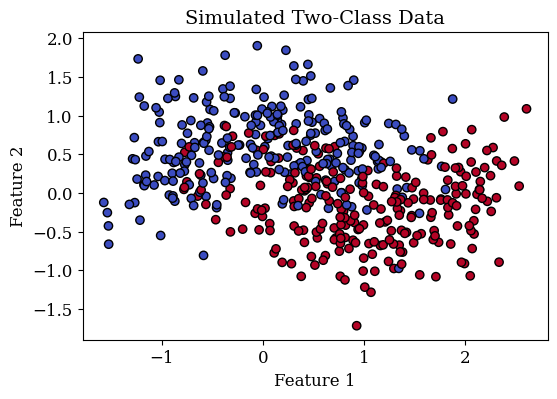

In [39]:
from sklearn.datasets     import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Generate a simulater two-class data
X, y = make_moons(n_samples=500, noise=0.40, random_state=0)

# Visualize the simulated data
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Two-Class Data')
plt.show()

We can clearly see that the data is very non-linear, which gives us a hint that the right model should be able to account for non-linear relationships. However, for demonstration purposes, I will be using logistic regression to generate an underfitting classifier; and while MLP is suitable for use here, I will let it generate an overfitting classifier by significantly oversizing the neurons and iterations.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)
under = LogisticRegression()

over  = MLPClassifier(hidden_layer_sizes=(200,200,200),
                      max_iter=2000,
                      random_state=1)

# Train both models
under.fit(X_train, y_train)
over.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 200, 200), max_iter=2000, random_state=1)

Then, we get the decision boundaries of the two classifiers and visualize them with the test data, what do you find about their accuracy?

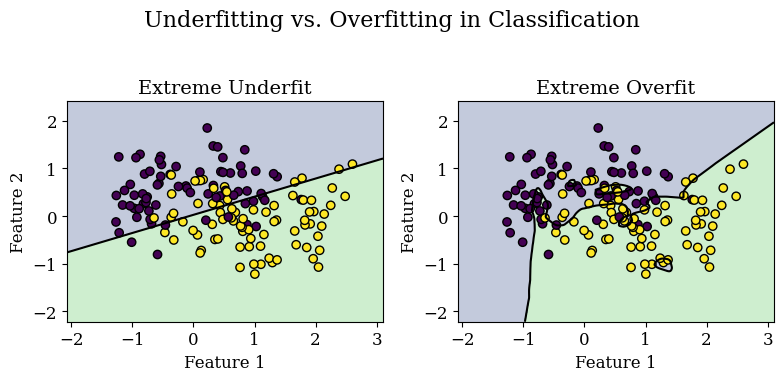

In [ ]:
# Build grid
x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Get decision boundary
Zu = under.predict_proba(grid)[:,1].reshape(xx.shape)
Zo = over.predict_proba(grid)[:,1].reshape(xx.shape)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

for ax, Z, title in [
    (ax1, Zu, 'Extreme Underfit'),
    (ax2, Zo, 'Extreme Overfit')
]:
    ax.contourf(xx, yy, Z>0.5, alpha=0.3)
    # draw precise decision boundary P=0.5
    ax.contour(   xx, yy, Z, levels=[0.5], colors='k', linewidths=1.5)

    ax.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

fig.suptitle('Underfitting vs. Overfitting in Classification', fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

We can tell easily from the above visualization that both scenarios are harmful: underfitting prevents the model from making meaningful predictions, while overfitting results in unreliable predictions on real-world data. The example above also highlights the necessity to validate classifier quality using test data.

While underfitting and overfitting can seem scary, there are many tools that have been developed to address this issue. We can adjust the complexity of the model, use regularization techniques, collect more data, or employ cross-validation to find a balance that generalizes well to new examples. These are left for you to explore on your own.

### Reference
1. Richter, G. M. A. (1970). *Kouroi: Archaic Greek youths: A study of the development of the Kouros type in Greek sculpture.* Phaidon. Accessed through Internet Archive <https://archive.org/details/kouroiarchaicgre0000rich>.
2. Pinecone. *Embedding Methods for Image Search.* Accessed through Pinecone <https://www.pinecone.io/learn/series/image-search/>.
3. IBM. What are convolutional neural networks? <https://www.ibm.com/think/topics/convolutional-neural-networks>
4. Hugging Face. Image Classification. <https://huggingface.co/docs/transformers/tasks/image_classification>
5. Coleman, C., Lyon, S., & Perla, J. (2020). Introduction to Economic Modeling and Data Science. QuantEcon. Retrieved from <https://datascience.quantecon.org/> 
6. Woo, S., Debnath, S., Hu, R., Chen, X., Liu, Z., Kweon, I. S., & Xie, S. (2024). ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders. arXiv preprint arXiv:2301.00808v1.
